In [0]:
from google.colab import drive
drive.mount('/content/drive/')
wrk_dir = '/content/drive/My Drive/INF730_Geolocation'
data_dir = wrk_dir + '/data'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


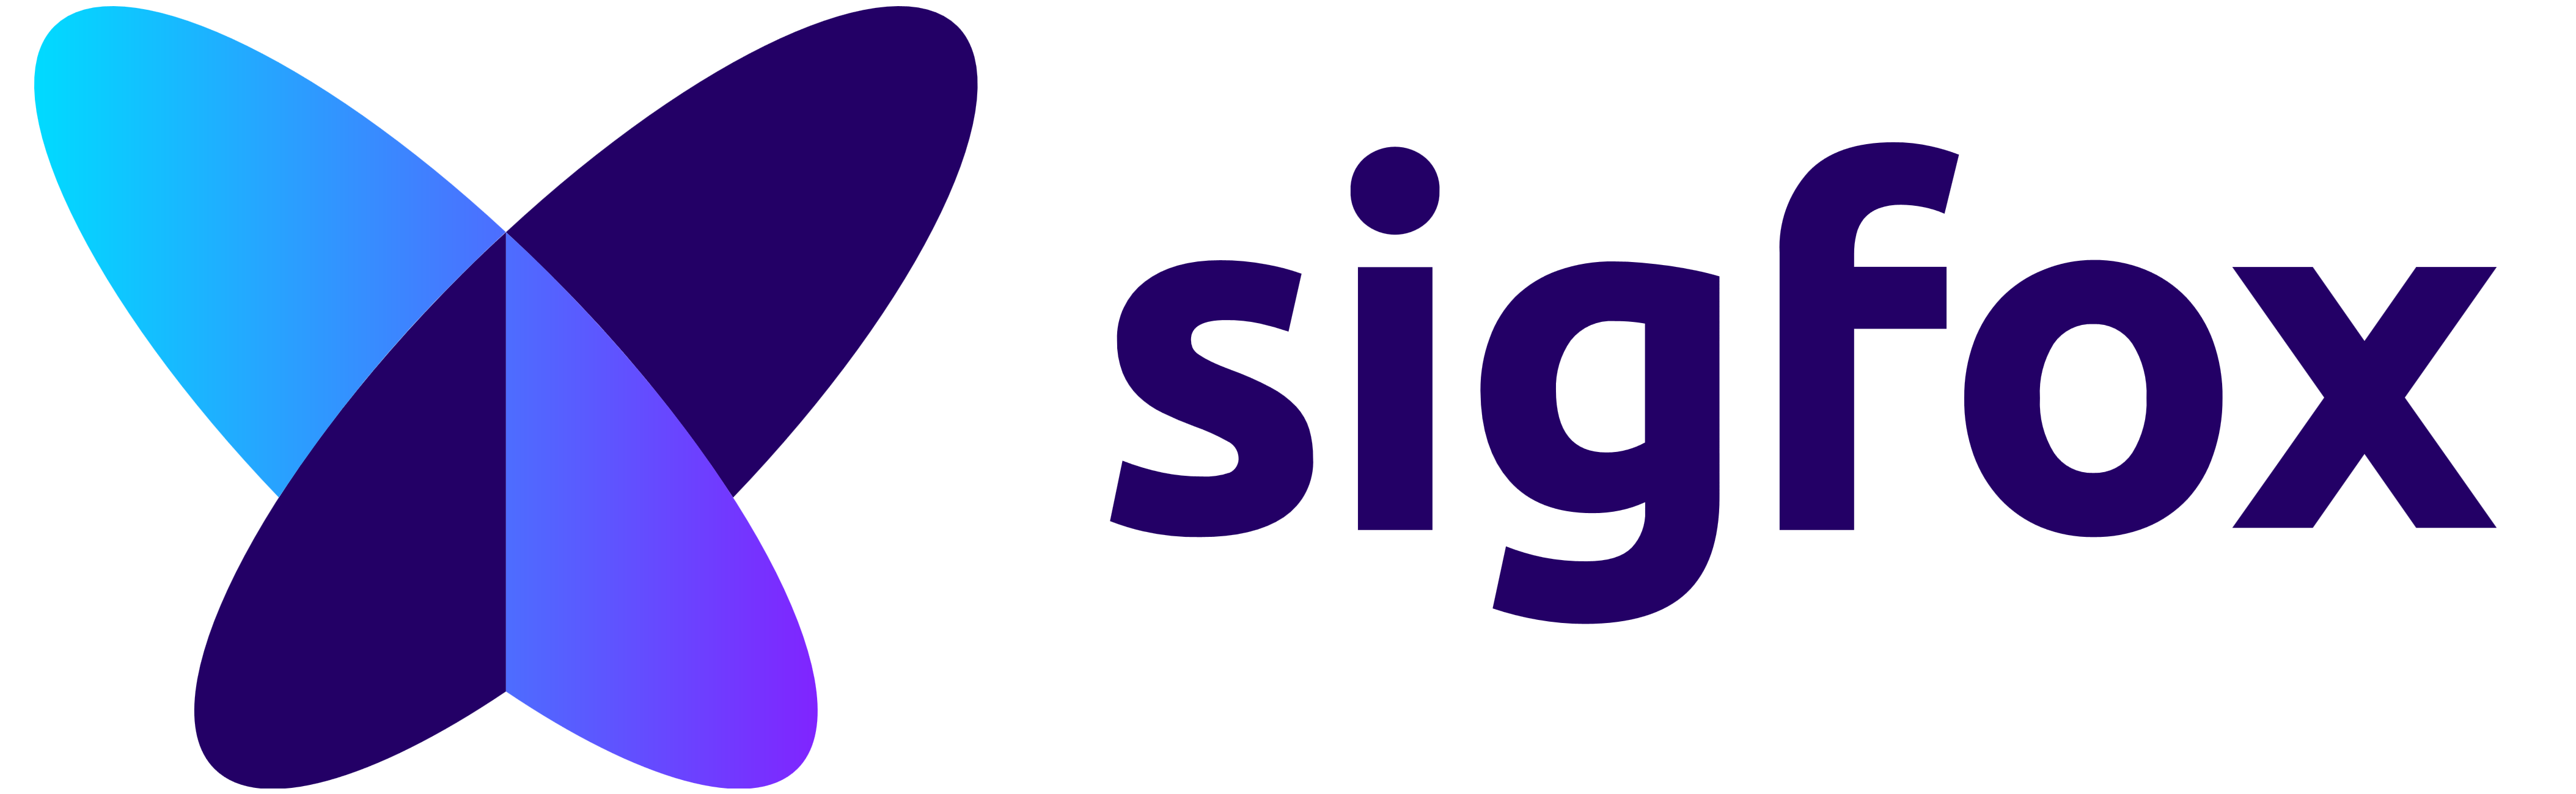

In [0]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/INF730_Geolocation/sigfox_logo.png", width=300)

# TP Geolocation 


## Context

The purpose of the project is to identify the location of sensors, knowing the message IDs and intensity of their signals received in different base stations.
We do know the longitude and latitude of these base stations.
The RSSI indicates the intensity of the signal.

<table style="margin-left: 2.0px;" class="confluenceTable"><colgroup><col><col><col></colgroup><tbody><tr><th style="text-align: center;" class="confluenceTh">RSSI</th><th style="text-align: center;" class="confluenceTh">Number of base stations</th><th style="text-align: center;" class="confluenceTh">Link Quality indicator</th></tr><tr><td class="confluenceTd">-114dBm &lt; RSSI</td><td class="confluenceTd">3</td><td class="confluenceTd">EXCELLENT</td></tr><tr><td class="confluenceTd">-127dBm &lt; RSSI <span>≤</span> -114dBm</td><td class="confluenceTd">3</td><td class="confluenceTd">GOOD</td></tr><tr><td class="confluenceTd">-114dBm &lt; RSSI</td><td class="confluenceTd">1 or 2</td><td class="confluenceTd">GOOD</td></tr><tr><td class="confluenceTd">-127dBm &lt; RSSI <span>≤</span> -114dBm</td><td class="confluenceTd">1 or 2</td><td class="confluenceTd">AVERAGE</td></tr><tr><td class="confluenceTd">RSSI <span>≤</span> -127dBm</td><td class="confluenceTd">any</td><td class="confluenceTd">LIMIT</td></tr></tbody></table>

Source: https://support.sigfox.com/docs/link-quality:-general-knowledge

The latitude value should be always between -90° et 90°. For values which are not included in this range, we can apply an axial symetry.

Source: https://www.itilog.com/fr


## Importation


In [0]:
%matplotlib inline
!pip install vincenty
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty

# Data Science librairies
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
import xgboost as xgb
from xgboost import XGBClassifier


# Tensorflow/Keras
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Lambda
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import math

# Save model
import pickle

# Map Visualization
import folium

import plotly.graph_objects as go
mapbox_access_token = "pk.eyJ1IjoicGxlZ291eCIsImEiOiJjazc0bHB4OHkwNmV0M2VwbDNrem42ODlmIn0.ywl8p9F5JUSQxlLB-IHFfQ"

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

kwargs = {'edgecolor': None, 'alpha': 0.7}
sns.set()
sns.set_style("white")
custom_palette = ['slateblue', 'tomato', 'orange', 'green', 'purple', 'salmon', 'gold', 'grey']
sns.set_palette(custom_palette)

In [0]:
# Saving keras models
def save_model(model, name, keras=False):
    """if model is made with keras, set keras=True"""
    if not keras:
        pickle.dump(model, open(wrk_dir + "/model/" + name + ".dat", "wb"))
    else:
        model.save(wrk_dir + "/model/" + name + ".h5")
        
    print("model saved under %s" % name)
    
def load_model(name, keras=False):
    """if model was made with keras, set keras=True. Model is then saved using TensorFlow SavedModel format."""
    if not keras:
        return pickle.load(open(wrk_dir + "/model/" + name + ".dat", "rb"))
    else:
        new_model = tf.keras.models.load_model(wrk_dir + "/model/" + name + ".h5")
        return new_model

## Loading data



In [0]:
# load train and test data
df_mess_train = pd.read_csv(data_dir + '/mess_train_list.csv') # train set
df_mess_test = pd.read_csv(data_dir + '/mess_test_list.csv') # test set
pos_train = pd.read_csv(data_dir + '/pos_train_list.csv') # position associated to train set

In [0]:
df_mess_train.head()
# df_mess_train.describe()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [0]:
pos_train.head()
# pos_train.describe()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [0]:
print('data', df_mess_train.shape)
print('label', pos_train.shape)

data (39250, 8)
label (39250, 2)


## Preprocessing to create features


In [0]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

print("size of list of Bs: %d \n" % len(listOfBs))

size of list of Bs: 259 



In [0]:
df_BS_loc = pd.concat([df_mess_train[['bsid', 'bs_lat', 'bs_lng']], df_mess_test[['bsid', 'bs_lat', 'bs_lng']]], axis=0)
df_BS_loc = df_BS_loc.drop_duplicates()
df_BS_loc.shape

(259, 3)

(6004, 2)


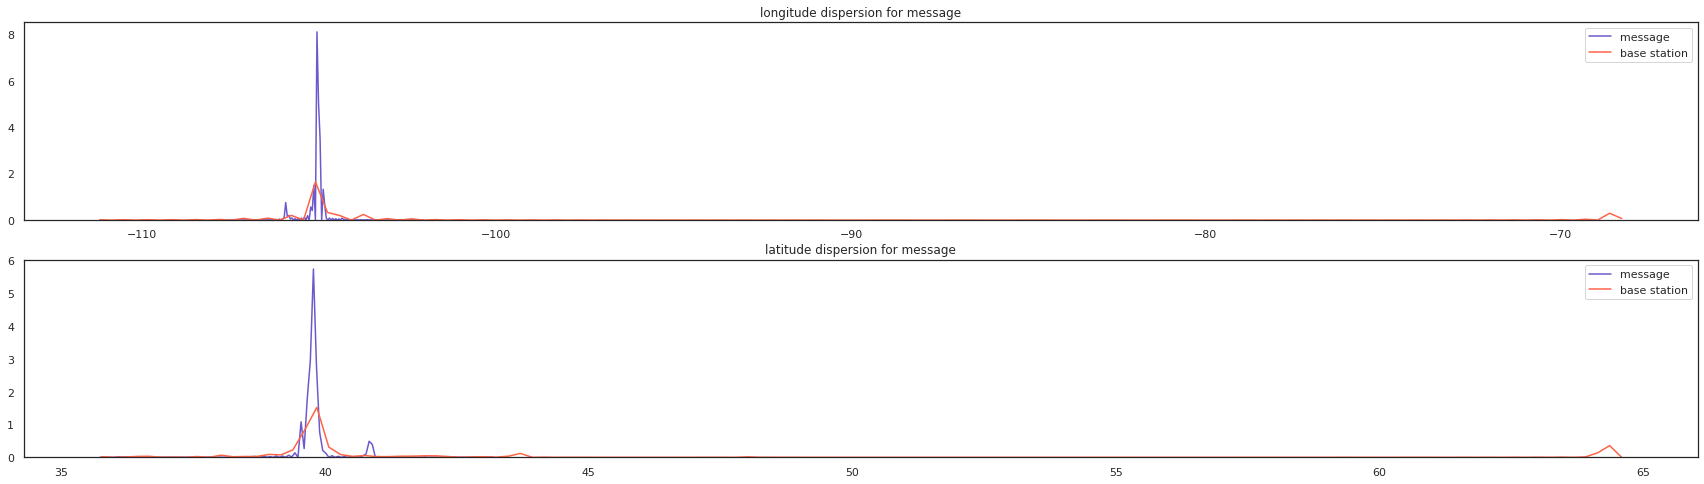

In [0]:
pos_train_unique = pos_train.drop_duplicates()
print(pos_train_unique.shape)

fig, ax = plt.subplots(2, 1, figsize=(30, 8))

sns.kdeplot(data=pos_train_unique.loc[:, 'lng'].values, ax=ax[0], label='message')
sns.kdeplot(data=df_BS_loc.loc[:, 'bs_lng'].values, ax=ax[0], color='tomato', label='base station')
ax[0].set_title("longitude dispersion for message")
ax[0].legend()

sns.kdeplot(data=pos_train_unique.loc[:, 'lat'].values, ax=ax[1], label='message')
sns.kdeplot(data=df_BS_loc.loc[:, 'bs_lat'].values, ax=ax[1], color='tomato', label='base station')
ax[1].set_title("latitude dispersion for message")
ax[1].legend()

plt.show()

We notice a normal distribution for signals (message) and base stations in latitude (around 39°) and longitude (around -105°).

In [0]:
#Group by message id
df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False)
df_mess_bs_group.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,476257.0,1.0,-128.000000,1.481140e+12,39.777690,-105.002424
39246,5848672e12f14360d7942374,8352,476257.0,0.0,-121.000000,1.481140e+12,39.761633,-105.025753
39247,5848672e12f14360d7942374,8397,476257.0,2.0,-126.000000,1.481140e+12,39.759396,-105.001415
39248,58487473e541cd0e133cca72,3051,476593.0,1.0,-131.333333,1.481143e+12,39.898872,-105.153832


In [0]:
# Group by base stations latitude and longitude
df_coord_group = df_mess_train.groupby(['bs_lat', 'bs_lng'], as_index=False)
df_coord_group.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216
...,...,...,...,...,...,...,...,...
35378,583d53bae541cd03e79707c8,2780,474192.0,1.0,-137.0,1.480414e+12,39.267888,-104.867256
36384,583da24412f1434b9ca36825,1971,474192.0,0.0,-137.0,1.480434e+12,39.160211,-104.834460
37071,583f767512f1434b9c16737c,2693,476207.0,1.0,-127.0,1.480554e+12,39.783726,-104.891607
37074,583f767512f1434b9c16737c,3385,476207.0,0.0,-135.0,1.480554e+12,39.893410,-104.841287


At this step, we can think about removing the outliers and keep only base stations where the signal is high.

In [0]:
def feat_mat_const(df_mess_train, listOfBs):
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    df_feat["did"] = 0
    i = 0
    list_messid = [0] * nb_mess
    list_nb_activated_bs = [0] * nb_mess
    for mid, row in df_mess_bs_group:
        l_bsid = row['bsid'].tolist()
        l_rssi = row['rssi'].tolist()
        l_did = row['did'].tolist()
        for bsid, rssi, did in zip(l_bsid, l_rssi,l_did):
            df_feat.loc[i, bsid] = rssi # + 160
            list_nb_activated_bs[i] += 1
            df_feat.loc[i, "did"] = did
        list_messid[i] = mid
        i += 1
    device_id = df_feat["did"].values  
    df_feat.drop("did",axis=1,inplace=True)
    
    return df_feat, list_messid, list_nb_activated_bs, device_id

In [0]:
df_feat, list_messid, list_nb_activated_bs, device_id = feat_mat_const(df_mess_train, listOfBs)
print("length of list of message id: {}".format(len(list_messid)))
print("length of count of activated bs: {}".format(len(list_nb_activated_bs)))
print("shape of feature matrix: {}".format(df_feat.shape))
df_feat.head()

length of list of message id: 6068
length of count of activated bs: 6068
shape of feature matrix: (6068, 259)


,879,911,921,944,980,1012,1086,1092,1120,1131,1148,1156,1187,1226,1229,1235,1237,1264,1266,1268,1292,1334,1344,1432,1443,1447,1463,1476,1526,1530,1534,1581,1594,1661,1730,1741,1743,1772,1796,1826,...,8384,8390,8392,8397,8401,8405,8426,8437,8442,8446,8449,8450,8451,8452,8453,8457,8470,8471,8472,8473,8474,8475,8495,8509,8560,8746,8747,9783,9784,9899,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-116.666667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-127.5,0.0,0.0,-139.0,-137.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-134.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                 0
count  6068.000000
mean      6.468359
std       8.997655
min       1.000000
25%       2.000000
50%       3.000000
75%       8.000000
max     106.000000


Text(0.5, 1.0, 'Number of activated base stations per message')

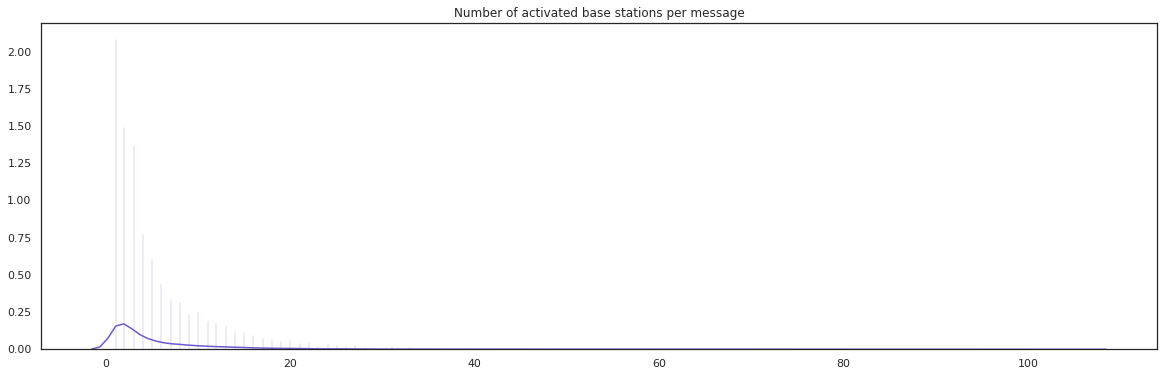

In [0]:
print(pd.DataFrame(list_nb_activated_bs).describe())
plt.figure(figsize=(20, 6))
sns.distplot(list_nb_activated_bs, bins=1000)
plt.title("Number of activated base stations per message")

### Cross Validation

In [0]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):
    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])

    data = {'lat': ground_truth_lat,
            'lng': ground_truth_lng
    }

    ground_truth_both = pd.DataFrame(data, columns=['lat', 'lng'])
    
    # 3 outputs: 
    #       - ground truth for latitude only (np.array)
    #       - ground truth longitude only (np.array)
    #       - ground truth for both (pd.DataFrame)
    return ground_truth_lat, ground_truth_lng, ground_truth_both

In [0]:
ground_truth_lat, ground_truth_lng, df_y = ground_truth_const(df_mess_train, pos_train)  # get ground_truth_both

#### Leave One Group Out

The device_id can generate a biais in the prediction, so we will remove it from the training and testing dataset. This drop is equivalent to a 'one group leave-out'.

In [0]:
groups = device_id
logo = LeaveOneGroupOut()
logo.get_n_splits(df_feat,df_y,groups)

113

In [0]:
def cross_val_pred(regressor,X,y,groups):
    logo = LeaveOneGroupOut()
    logo.get_n_splits(X,y,groups)
    cvp = cross_val_predict(regressor,X,y,groups=groups,cv=logo)
    return cvp

## Training a Multi-target Regressor


In [0]:
# Train validation split
X_train, X_valid, y_train, y_valid = train_test_split(df_feat, df_y, test_size=0.10, random_state=42)

In [0]:
print(X_train.shape)
print(y_train.shape)

(5461, 259)
(5461, 2)


In [0]:
print(X_valid.shape)
print(y_valid.shape)

(607, 259)
(607, 2)


### XGBoost Regressor


In [0]:
# Train the classifier on a part of the data set
param={'objective':'reg:squarederror', 
       'learning_rate': 0.05, 
       'n_estimators':400,
       'eval_metric':['rmse'],
       'max_depth':20,
       'alpha': 10.,  # L1 regularization parameter
       'lambda': 10., # L2 regularization parameter
       # performance
       'n_jobs':-1,
      #  'gpu_id':0,
      #  'tree_method':'gpu_hist'
      }
 
xgb_model_lat = xgb.XGBRegressor(**param)
xgb_model_lng = xgb.XGBRegressor(**param)

In [0]:
xgb_model_lat.fit(X_train.values, y_train['lat'].values)

XGBRegressor(alpha=10.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric=['rmse'],
             gamma=0, importance_type='gain', lambda=10.0, learning_rate=0.05,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
             n_estimators=400, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [0]:
xgb_model_lng.fit(X_train.values, y_train['lng'].values)

XGBRegressor(alpha=10.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric=['rmse'],
             gamma=0, importance_type='gain', lambda=10.0, learning_rate=0.05,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
             n_estimators=400, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [0]:
save_model(xgb_model_lat, "xgboost_lat", keras=False)
save_model(xgb_model_lng, "xgb_model_lng", keras=False)

model saved under xgboost_lat
model saved under xgb_model_lng


In [0]:
xgb_model_lat = load_model("xgboost_lat", keras=False)
xgb_model_lng = load_model("xgb_model_lng", keras=False)

In [0]:
y_valid_lat_pred = xgb_model_lat.predict(X_valid.values)
y_valid_lng_pred = xgb_model_lng.predict(X_valid.values)
y_valid_pred_xgb = np.array([[lat, lng] for lat, lng in zip(y_valid_lat_pred, y_valid_lng_pred)])

In [0]:
np.mean(np.abs(y_valid_lat_pred - y_valid['lat'].values))

0.023732999490234476

In [0]:
np.mean(np.abs(y_valid_lng_pred - y_valid['lng'].values))

0.019254803083254033

### KNN regressor



We tried several values for *n_neighbors*. The value used (8) seemed like the better option.


In [0]:
knn_model = KNeighborsRegressor(n_neighbors=8, n_jobs=-1, weights='distance')


Using cross-validation on whole dataset:

In [0]:
y_pred = cross_val_pred(knn_model, df_feat, df_y, device_id)
y_lat_pred = np.array([coord[0] for coord in y_pred])
y_lng_pred = np.array([coord[1] for coord in y_pred])

In [0]:
np.mean(np.abs(y_lat_pred - df_y['lat'].values))

0.04847482964694238

In [0]:
np.mean(np.abs(y_lng_pred - df_y['lng'].values))

0.038789259139503894

Fitting on a training sample (90%) and validating on remaining data (10%):



In [0]:
knn_model.fit(X_train.values, y_train.values)

y_valid_pred_knn = knn_model.predict(X_valid.values)
y_valid_lat_pred = np.array([coord[0] for coord in y_valid_pred_knn])
y_valid_lng_pred = np.array([coord[1] for coord in y_valid_pred_knn])

In [0]:
# np.mean(np.abs(y_knn_lat_pred - y_valid['lat'].values))
np.mean(np.abs(y_valid_lat_pred - y_valid['lat'].values))

0.02024794450516252

In [0]:
np.mean(np.abs(y_valid_lng_pred - y_valid['lng'].values))

0.016469915637274832

The KNN regressor gives a smaller error.

### Feed-Forward Neural Network


In [0]:
def haversine_loss(y_true, y_pred):
    """harvesine distance between two points with R = 6371e3"""
    R = 6371* (10**3)
    # conversion to radian
    lat_t = y_true[0] * math.pi/180  # true latitude
    lat_p = y_pred[0] * math.pi/180  # pred
    lng_t = y_true[1] * math.pi/180  # true longitude
    lng_p = y_pred[1] * math.pi/180  # pred

    dlng = lng_t - lng_p
    dlat = lat_t - lat_p

    a = K.sin(dlat/2)**2 + K.cos(lat_t)*K.cos(lat_p)*(K.sin(dlng/2)**2)
    c = 2 * (tf.atan2(K.sqrt(a), K.sqrt(1-a)))

    return K.abs(c * R)  # distance in meters

# def mean_harvesine_loss(y_true, y_pred):
#     return K.mean(haversine_loss(y_true, y_pred))

In [0]:
model = Sequential([
    Dense(40, activation='linear', 
          activity_regularizer=regularizers.l1_l2(l1=0.1,l2=0.1)),
    Activation('relu'),
    Dense(20, activation='linear',
          activity_regularizer=regularizers.l1_l2(l1=0.1,l2=0.1)),
    Activation('relu'),
    Dense(10, activation='linear',
          activity_regularizer=regularizers.l1_l2(l1=0.1,l2=0.1)),
    Activation('sigmoid'),
    Dense(2, activation='linear')
])

model.compile(loss=haversine_loss,
              optimizer="adam",
              metrics=["mse"])   # Mean square Error

In [0]:
EPOCHS = 200

top = time.time()

history = model.fit(X_train.values, y_train.values,
                    validation_data=(X_valid.values, y_valid.values),
                    epochs=EPOCHS,
                    verbose=1)

diff = time.time() - top
print("Execution time: {}m {:02d}s".format(int(diff / 60), int(diff) % 60))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5461 samples, validate on 607 samples
Epoch 1/200
5461/5461 [==============================] - 1s 134us/sample - loss: 7623847.0268 - mean_squared_error: 6179.8008 - val_loss: 7525786.4806 - val_mean_squared_error: 6058.3748
Epoch 2/200
5461/5461 [==============================] - 0s 75us/sample - loss: 7440394.0508 - mean_squared_error: 5959.2809 - val_loss: 7362602.2919 - val_mean_squared_error: 5867.7358
Epoch 3/200
5461/5461 [==============================] - 0s 77us/sample - loss: 7290355.2309 - mean_squared_error: 5783.2600 - val_loss: 7220345.6150 - val_mean_squared_error: 5698.8427
Epoch 4/200
5461/5461 [==============================] - 0s 77us/sample - loss: 7147325.9719 - mean_squared_error: 5616.6406 - val_loss: 7073148.7776 - val_mean_squared_error: 5534.1506
Epoch 5/200
5461/5461 [==========

In [0]:
save_model(model, "nn_model", keras=True)

model saved under nn_model


In [0]:
nn_model = load_model("nn_model", keras=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
y_valid_pred_ffnn = nn_model.predict(X_valid.values)
y_valid_lat_pred = np.array([coord[0] for coord in y_valid_pred_ffnn])
y_valid_lng_pred = np.array([coord[1] for coord in y_valid_pred_ffnn])

In [0]:
np.mean(np.abs(y_valid_lat_pred - y_valid['lat'].values))

0.08184853918953369

In [0]:
np.mean(np.abs(y_valid_lng_pred - y_valid['lng'].values))

0.06497561076728876

### Linear Regression


Despite our best effort, the results remained really bad. Thus we didn't investigate further this algorithm

In [0]:
# def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
  
#     # train regressor and make prediction in the train set
#     # Input: df_feat: feature matrix used to train regressor
#     #        ground_truth_lat: df_feat associated latitude
#     #        ground_truth_lng: df_feat associated longitude
#     #        df_test: data frame used for prediction
#     # Output: y_pred_lat, y_pred_lng

#     X_train = np.array(df_feat)
#     X_test = np.array(df_test)
#     reg = LinearRegression()


#     reg.fit(X_train, ground_truth_lat)
#     y_pred_lat = reg.predict(X_test) 

#     reg.fit(X_train, ground_truth_lng)
#     y_pred_lng = reg.predict(X_test) 
    
#     latitude_normalization(y_pred_lat)
    
#     return y_pred_lat, y_pred_lng

In [0]:
#y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

## Evaluating the result



The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

The "Earth radius" R varies from 6356.752 km at the poles to 6378.137 km at the equator. More importantly, the radius of curvature of a north-south line on the earth's surface is 1% greater at the poles (≈6399.594 km) than at the equator (≈6335.439 km).

In [0]:
# Evaluate result using harvesine_ distance on numpy array
def haversine_distance(y_true, y_pred):
    """harvesine distance between two points with R = 6371e3"""
    R = 6371* (10**3)
    # true
    y_lat_true = np.array([coord[0] for coord in y_true]) * math.pi/180
    y_lng_true = np.array([coord[1] for coord in y_true]) * math.pi/180
    # pred
    y_lat_pred = np.array([coord[0] for coord in y_pred]) * math.pi/180
    y_lng_pred = np.array([coord[1] for coord in y_pred]) * math.pi/180

    l_distance = []
    for lat_t, lng_t, lat_p, lng_p in zip(y_lat_true, y_lng_true, y_lat_pred, y_lng_pred):
        # conversion to radian

        dlng = lng_t - lng_p
        dlat = lat_t - lat_p

        a = math.sin(dlat/2)**2 + math.cos(lat_t)*math.cos(lat_p)*(math.sin(dlng/2)**2)
        c = 2 * (math.atan2(math.sqrt(a), math.sqrt(1-a)))

        l_distance.append(abs(c * R))

    return l_distance # distance in meters

#### Error vector with haversine *distance*



In [0]:
err_vec_haversine_knn = haversine_distance(y_valid.values, y_valid_pred_knn)

In [0]:
err_80_haversine_knn = np.percentile(err_vec_haversine_knn, 80)
print(err_80_haversine_knn)

3242.566890602623


K-NN distance error distribution according to haversine_distance method


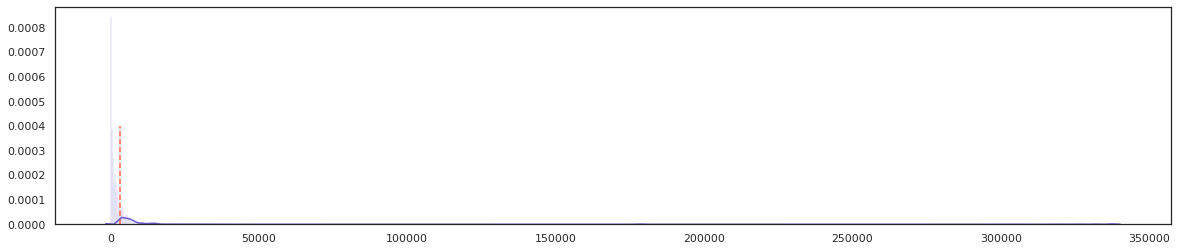

In [0]:
plt.figure(figsize=(20,4))
sns.distplot(err_vec_haversine_knn, bins=1000)
plt.vlines(err_80_haversine_knn, ymin=0, ymax=0.0004, colors='tomato', linestyles='dashed')

The haversine formula and law of cosines cannot be guaranteed correct to better than 0.5%. More accurate methods that consider the Earth's ellipticity are given by Vincenty's formulae.

#### Error vector with vincenty distance


In [0]:
def vincenty_vec(vec_coord):
    print(vec_coord.shape)
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    # print(vec_coord)
    
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [0]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([e for e in zip(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng)])
    err_vec = vincenty_vec(vec_coord)
    
    return err_vec

In [0]:
err_vec_knn = Eval_geoloc(y_valid['lat'].values , y_valid['lng'].values, np.array([coord[0] for coord in y_valid_pred_knn]), np.array([coord[1] for coord in y_valid_pred_knn]))
err_vec_ffnn = Eval_geoloc(y_valid['lat'].values , y_valid['lng'].values, np.array([coord[0] for coord in y_valid_pred_ffnn]), np.array([coord[1] for coord in y_valid_pred_ffnn]))
err_vec_xgb = Eval_geoloc(y_valid['lat'].values , y_valid['lng'].values, np.array([coord[0] for coord in y_valid_pred_xgb]), np.array([coord[1] for coord in y_valid_pred_xgb]))
# err_vec = Eval_geoloc(y_valid.values, y_valid_pred)

(607, 4)
(607, 4)
(607, 4)


In [0]:
# Error criterion
err_80_vincenty_knn = np.percentile(err_vec_knn, 80)
print(err_80_vincenty_knn)
err_80_vincenty_ffnn = np.percentile(err_vec_ffnn, 80)
print(err_80_vincenty_ffnn)
err_80_vincenty_xgb = np.percentile(err_vec_xgb, 80)
print(err_80_vincenty_xgb)

3250.1121402156023
10265.789503440003
3755.891256725647


#### Plot error distribution with Vincenty

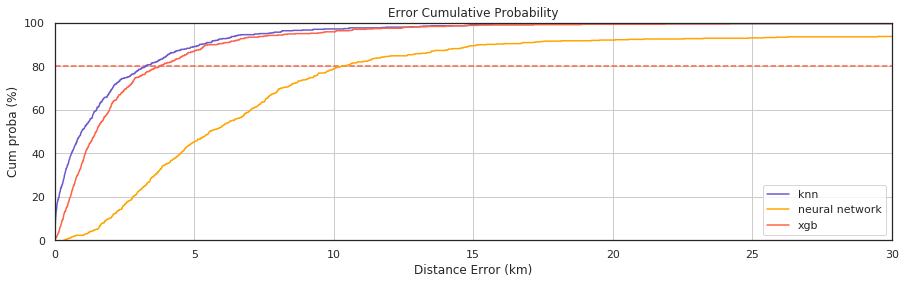

In [0]:
values_knn, base_knn = np.histogram(err_vec_knn, bins=50000)
values_ffnn, base_ffnn = np.histogram(err_vec_ffnn, bins=50000)
values_xgb, base_xgb = np.histogram(err_vec_xgb, bins=50000)

cumulative_knn = np.cumsum(values_knn)
cumulative_ffnn = np.cumsum(values_ffnn)
cumulative_xgb = np.cumsum(values_xgb)

plt.figure(figsize=(15,4))

plt.plot(base_knn[:-1]/1000, cumulative_knn / np.float(np.sum(values_knn))  * 100.0, color='slateblue', label='knn')
plt.plot(base_ffnn[:-1]/1000, cumulative_ffnn / np.float(np.sum(values_ffnn))  * 100.0, color='orange', label='neural network')
plt.plot(base_xgb[:-1]/1000, cumulative_xgb / np.float(np.sum(values_xgb))  * 100.0, color='tomato', label='xgb')

plt.hlines(80, xmin=0, xmax=30, colors='tomato', linestyles='dashed')

plt.grid()

plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100])

plt.title('Error Cumulative Probability')
plt.legend()

K-NN distance error distribution according to vincenty_distance method


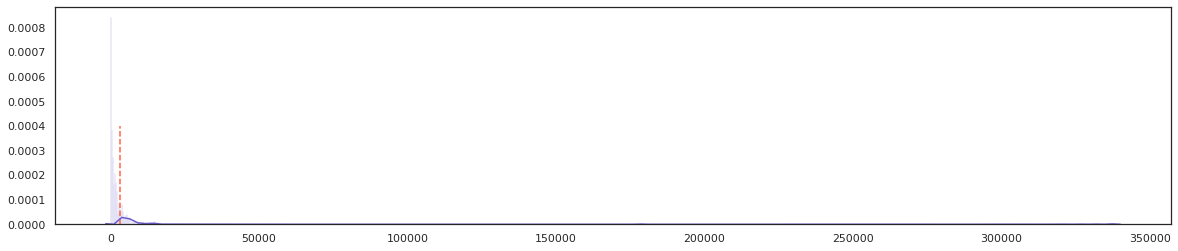

In [0]:
plt.figure(figsize=(20,4))
sns.distplot(err_vec_knn, bins=1000)
plt.vlines(err_80_vincenty_knn, ymin=0, ymax=0.0004, colors='tomato', linestyles='dashed')

## Prediction on test sample





We use the k-NN method (that was the most accurate) to predict on test sample

In [0]:
# Construct test prediction
X_test, list_messid_test, list_nb_activated_bs, device_id = feat_mat_const(df_mess_test, listOfBs)
print(X_test.shape)
X_test.head()

(5294, 259)


,879,911,921,944,980,1012,1086,1092,1120,1131,1148,1156,1187,1226,1229,1235,1237,1264,1266,1268,1292,1334,1344,1432,1443,1447,1463,1476,1526,1530,1534,1581,1594,1661,1730,1741,1743,1772,1796,1826,...,8384,8390,8392,8397,8401,8405,8426,8437,8442,8446,8449,8450,8451,8452,8453,8457,8470,8471,8472,8473,8474,8475,8495,8509,8560,8746,8747,9783,9784,9899,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-133.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# y_test_lat_pred = xgb_model_lat.predict(X_test.values)
# y_test_lng_pred = xgb_model_lng.predict(X_test.values)
# y_test_pred = np.array([[lat, lng] for lat, lng in zip(y_test_lat_pred, y_test_lng_pred)])
y_test_pred = knn_model.predict(X_test.values)
y_test_lat_pred = np.array([coord[0] for coord in y_test_pred])
y_test_lng_pred = np.array([coord[1] for coord in y_test_pred])

In [0]:
df_y_test_pred = pd.DataFrame(y_test_pred).rename(columns={0:'lat', 1:'lng'})
df_y_test_pred.index = list_messid_test
df_y_test_pred.index.name = 'messid'
df_y_test_pred.head()

,lat,lng
messid,,
573be2503e952e191262c351,39.718860,-105.059970
573c05f83e952e1912758013,39.774778,-105.077968
573c0796f0fe6e735a66deb3,39.683995,-105.014385
573c08d2864fce1a9a0563bc,39.803398,-105.080390
573c08ff864fce1a9a0579b0,39.684225,-105.014431


In [0]:
df_mess_test_reindexed = df_mess_test.set_index('messid')
df_mess_test_reindexed = df_mess_test_reindexed.merge(df_y_test_pred, how='left', on='messid')
df_mess_test_reindexed.head()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
messid,,,,,,,,,
573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032,39.718860,-105.059970
573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479,39.774778,-105.077968
573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676,39.774778,-105.077968
573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032,39.774778,-105.077968
573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747,39.774778,-105.077968


In [0]:
df_mess_test_reindexed.isnull().sum()  # Verification if merge was indeed successful

bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
lat        0
lng        0
dtype: int64

#### Saving predictions on tests

Using *pos_train_list.csv* format:


In [0]:
df_test_submission = df_mess_test_reindexed.reset_index()[['lat', 'lng']]
df_test_submission.to_csv(wrk_dir + '/pred_pos_test_list.csv', index=False)   # save predicted location to pos_test_list.csv

Prediction of latitude/longitude for each messid:


In [0]:
df_y_test_pred_submission = df_y_test_pred.reset_index()
col_messid = df_y_test_pred_submission['messid']
df_y_test_pred_submission = df_y_test_pred_submission.drop(['messid'], axis=1)
df_y_test_pred_submission['messid'] = col_messid
df_y_test_pred_submission.head()

,lat,lng,messid
0,39.718860,-105.059970,573be2503e952e191262c351
1,39.774778,-105.077968,573c05f83e952e1912758013
2,39.683995,-105.014385,573c0796f0fe6e735a66deb3
3,39.803398,-105.080390,573c08d2864fce1a9a0563bc
4,39.684225,-105.014431,573c08ff864fce1a9a0579b0


In [0]:
df_y_test_pred_submission.to_csv(wrk_dir + '/pred_pos_test_per_messid.csv', index=False)

## Visualisation on Map





In [0]:
df_BS_loc.head()

,bsid,bs_lat,bs_lng
0,2841,39.617794,-104.954917
1,3526,39.677251,-104.952721
2,2605,39.612745,-105.008827
3,2610,39.797969,-105.073460
4,3574,39.723151,-104.956216


### Training Data


In [0]:
fig = go.Figure()

# Trace 0: Base station
fig.add_trace(go.Scattermapbox(
        name="bs",
        lat=df_BS_loc.loc[:, 'bs_lat'].values,
        lon=df_BS_loc.loc[:, 'bs_lng'].values,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            color='rgb(50, 30, 240)',
            opacity=1.
        ),
        text=df_BS_loc.index,
        hoverinfo="all"
    ))

# Trace 1: ground truth location on training data
fig.add_trace(go.Scattermapbox(
        name="mess_pos",
        lat=pos_train['lat'].values,
        lon=pos_train['lng'].values,
        mode='markers',
        marker=dict(
            size=10,
            color='rgb(50, 240, 30)',
            opacity=0.5
        ),
        text=pos_train.index,
        hoverinfo="all"
    ))

fig.update_layout(
    title='mesage',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40,
            lon=-105
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)


fig.show()

We notice that there are outliers, that we can remove.

### Predictions on Validation sample

In [0]:
fig = go.Figure()

# Trace 0: Base station
fig.add_trace(go.Scattermapbox(
        name="bs",
        lat=df_BS_loc.loc[:, 'bs_lat'].values,
        lon=df_BS_loc.loc[:, 'bs_lng'].values,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            color='rgb(50, 30, 240)',
            opacity=1.
        ),
        text=df_BS_loc.index,
        hoverinfo="all"
    ))

# Trace 1: ground truth location on validation set (10% of training set)
fig.add_trace(go.Scattermapbox(
        name="mess_pos",
        lat=y_valid['lat'].values,
        lon=y_valid['lng'].values,
        mode='markers',
        marker=dict(
            size=10,
            color='rgb(50, 240, 30)',
            opacity=0.5
        ),
        text=y_valid.index,
        hoverinfo="all"
    ))

# Trace 2: prediction on validation set 10% of training set)
fig.add_trace(go.Scattermapbox(
        name="mess_pos_pred",
        lat=np.array([coord[0] for coord in y_valid_pred_knn]),  # lat
        lon=np.array([coord[1] for coord in y_valid_pred_knn]),  # lng
        mode='markers',
        marker=dict(
            size=10,
            color='rgb(240, 30, 50)',
            opacity=0.5
        ),
        text=y_valid.index,
        hoverinfo="all"
    ))

df_lng_lat = pd.DataFrame(data={'lat_truth': y_valid['lat'].values,
                                'lat_pred': np.array([coord[0] for coord in y_valid_pred_knn]),  # lat
                                'lng_truth': y_valid['lng'].values,
                                'lng_pred': np.array([coord[1] for coord in y_valid_pred_knn])},  # lng
                          columns=['lat_pred', 'lat_truth', 
                                   'lng_pred', 'lng_truth'])

# Trace 3+: Lines to visualize dispersion of prediction compared to ground truth (validation)
for i in df_lng_lat.index:
    fig.add_trace(
        go.Scattermapbox(
            name="error_line",
            lon=[df_lng_lat.loc[i,'lng_pred'], df_lng_lat.loc[i,'lng_truth']],
            lat=[df_lng_lat.loc[i,'lat_pred'], df_lng_lat.loc[i,'lat_truth']],
            mode='lines',
            line=dict(width=1., color='red'),
        )
    )


fig.update_layout(
    title='mesage',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40,
            lon=-105
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)


fig.show()

# Annexe


In [0]:
# m = folium.Map(width=1200, height=600)
# # for i in df_BS_loc.index:
# #     folium.Circle( 
# #       location=[df_BS_loc.loc[i, 'bs_lat'],df_BS_loc.loc[i, 'bs_lng']],
# #       radius=10,
# #       color='crimson',
# #       fill=True,
# #       fill_color='crimson'
# #    ).add_to(m)

# for i in pos_train_unique.index:
#     folium.Circle( 
#       location=[pos_train_unique.loc[i, 'lat'],pos_train_unique.loc[i, 'lng']],
#       radius=10,
#       color='crimson',
#       fill=True,
#       fill_color='crimson'
#    ).add_to(m)

# m
messids = np.unique(np.array(df_mess_train['messid']))[:10]
pos_list = list()
for mess_id in messids:
    pos_list.append(pos_train[df_mess_train.messid==mess_id].iloc[0,].tolist())
    
mymap = folium.Map(location=np.mean(pos_list, axis=0).tolist(), zoom_start=10, width=1200, height=600)

for mess in messids:
  mask = df_mess_train['messid']==mess_id
  bs_id = df_mess_train[mask]['bsid']
  bs_coord = np.array(df_mess_train[mask][['bs_lat', 'bs_lng']])
  mess_id = df_mess_train[mask].iloc[0,0]
  did_id = df_mess_train[mask].iloc[0,2]
  did_coord = np.array(pos_train[mask].iloc[0,]).tolist()

  folium.Marker(location = did_coord, popup='Sending mess_id (' + mess_id + ') from did_id ' + str(did_id), icon=folium.Icon(color='red')).add_to(mymap)
  for bs_id, bs_coord in zip(bs_id, bs_coord):
    folium.Marker(location = bs_coord, popup='bsid : ' + str(bs_id)).add_to(mymap)
    folium.PolyLine(locations=[did_coord, bs_coord], color='blue').add_to(mymap)

mymap

In [0]:
from xgboost import *
def xgb_regressor (df_feat, ground_truth_lat, ground_truth_lng, df_test):
    X_train = np.array(df_feat)
    X_test = np.array(df_test)

    xgb_mod = xgb.XGBRegressor(n_estimators=100, learning_rate=0.2, nthread=4, max_depth=8)

    xgb_mod.fit(X_train, ground_truth_lat)
    y_pred_lat = xgb_mod.predict(X_test)

    xgb_mod.fit(X_train, ground_truth_lng)
    y_pred_lng = xgb_mod.predict(X_test)

    return y_pred_lat, y_pred_lng

In [0]:
  def RandomForest_Regressor (df_feat, ground_truth_lat, ground_truth_lng, df_test):
  
    X_train = np.array(df_feat);
    X_test = np.array(df_test);
   
    rf = RandomForestRegressor(random_state=0, n_estimators=n, n_jobs=-1)
    rf.fit(X_train, ground_truth_lat);
    y_pred_lat = rf.predict(X_test) 

    rf.fit(X_train, ground_truth_lng);
    y_pred_lng = rf.predict(X_test)
    
    return y_pred_lat, y_pred_lng

In [0]:
# # Feature Matrix construction 

# def feat_mat_const(df_mess_train, listOfBs):
#     df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
#     nb_mess = len(np.unique(df_mess_train['messid']))
#     df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    
#     i = 0
#     list_messid = [0] * nb_mess
#     list_nb_activated_bs = [0] * nb_mess
#     for mid, row in df_mess_bs_group:
#         l_bsid = row['bsid'].tolist()
#         l_rssi = row['rssi'].tolist()
#         for bsid, rssi in zip(l_bsid, l_rssi):
#             df_feat.loc[i, bsid] = rssi # + 160
#             list_nb_activated_bs[i] += 1
#         list_messid[i] = mid
#         i += 1
    
#     return df_feat, list_messid, list_nb_activated_bs # add id value of each message for the correspondance to message